[TOC](../toc.ipynb)

Applications of autograd
========================

- KEYWORDS: autograd


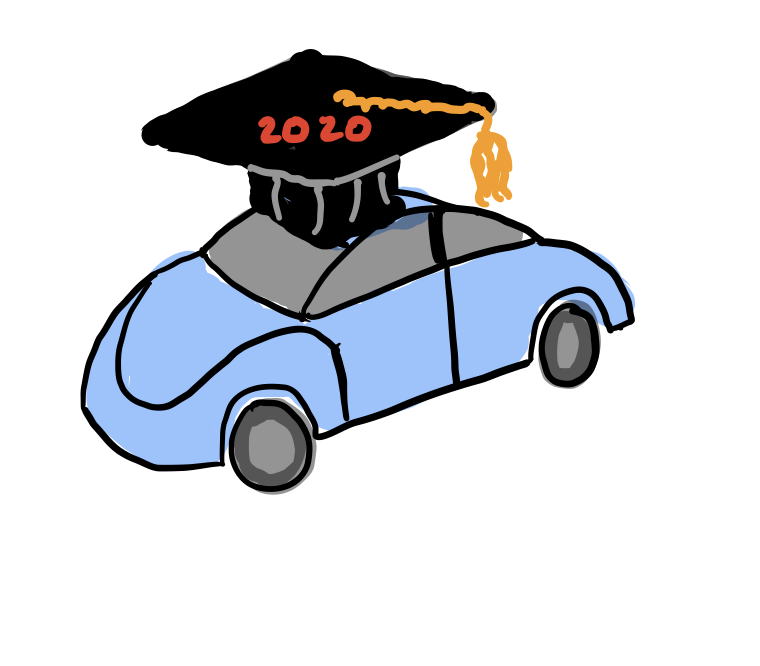
Yep. Its an autograd.

## Mathematical, scientific and engineering applications of autograd



### Evaluating line integrals



A line integral is an integral of a function along a curve in space. We usually represent the curve by a parametric equation, e.g. $\mathbf{r}(t) = [x(t), y(t), z(t)] = x(t)\mathbf{i} + y(t)\mathbf{j} + z(t)\mathbf{k}$.  So, in general the curve will be a vector function, and the function we want to integrate will also be a vector function.

Then, we can write the line integral definition as:

$\int_C \mathbf{F(r)} \cdot d\mathbf{r} = \int_a^b \mathbf{F}(\mathbf{r}(t)) \cdot \mathbf{r'}(t) dt$ where $\mathbf{r'}(t) = \frac{d\mathbf{r}}{dt}$. This integrand is a scalar function, because of the dot product.

The following examples are adapted from Chapter 10 in Advanced Engineering Mathematics by Kreysig.

The first example is the evaluation of  a line integral in the plane. We want to evaluate the integral of $\mathbf{F(r)}=[-y, -xy]$ on the curve $\mathbf{r(t)}=[-sin(t), cos(t)]$ from t=0 to t = &pi;/2. The answer in the book is given as 0.4521. Here we evaluate this numerically, using autograd for the relevant derivative. Since the curve has multiple outputs, we have to use the jacobian function to get the derivatives. After that, it is a simple bit of matrix multiplication, and a call to the quad function.

In [1]:
from jax.config import config

config.update("jax_enable_x64", True)

import jax.numpy as np

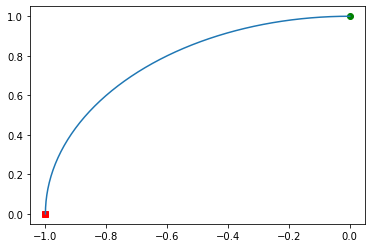

In [2]:
t = np.linspace(0, np.pi / 2)
import matplotlib.pyplot as plt

x = -np.sin(t)
y = np.cos(t)
plt.plot(x[0], y[0], "go")
plt.plot(x[-1], y[-1], "rs")
plt.plot(x, y);

In [3]:
from jax import jacrev
from scipy.integrate import quad


def F(X):
    x, y = X
    return np.array([-y, -x * y])


def r(t):
    return np.array([-np.sin(t), np.cos(t)])


drdt = jacrev(r)  # programming with a derivative


def integrand(t):
    return F(r(t)) @ drdt(t)


I, e = quad(integrand, 0.0, np.pi / 2)
print(f"The integral is {I:1.4f}.")

The integral is 0.4521.


In [4]:
r(0), drdt(0.0), F(r(0))  # checking what these all return

(DeviceArray([-0.,  1.], dtype=float64),
 DeviceArray([-1., -0.], dtype=float64, weak_type=True),
 DeviceArray([-1.,  0.], dtype=float64))

In [5]:
drdt(1.0) @ F(r(1.0))  # we are integrating (Accumulating) this value along the path

DeviceArray(-0.09064712, dtype=float64)

We get the same result as the analytical solution.



### Constrained optimization with Lagrange multipliers and autograd



Constrained optimization is common in engineering problems solving. A prototypical example (from Greenberg, Advanced Engineering Mathematics, Ch 13.7) is to find the point on a plane that is closest to the origin. The plane is defined by the equation $2x - y + z = 3$, and we seek to minimize $x^2 + y^2 + z^2$ subject to the equality constraint defined by the plane. `scipy.optimize.minimize` provides a pretty convenient interface to solve a problem like this, as shown here.



In [6]:
# import numpy as np
from scipy.optimize import minimize


def objective(X):
    x, y, z = X
    return x**2 + y**2 + z**2


def eq(X):
    x, y, z = X
    return 2 * x - y + z - 3


sol = minimize(objective, [1, -0.0, 0.0], constraints={"type": "eq", "fun": eq})
sol

     fun: 1.5000000006671164
     jac: array([ 2.00002983, -0.99997018,  0.99997017])
 message: 'Optimization terminated successfully'
    nfev: 22
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ 1.00001491, -0.4999851 ,  0.49998508])

I like the minimize function a lot, although I do not love how the constraints are provided.
Sometimes, it might be desirable to go back to basics though, especially if you are unaware of the `minimize` function or perhaps suspect it is not working right and want an independent answer. Next we look at how to construct this constrained optimization problem using Lagrange multipliers. This converts the problem into an augmented unconstrained optimization problem we can use `fsolve` on. The gist of this method is we formulate a new problem:

$F(L) = f(X) - \lambda g(X)$

and then solve the simultaneous resulting equations:

$F_x(L) = F_y(L) = F_z(L) = g(X) = 0$ where $F_x$ is the derivative of $F(L)$ with respect to $x$, and $g(X)$ is the equality constraint written so it is equal to zero. Since we end up with four equations that equal zero, we can simply use fsolve to get the solution. Many [years ago](http://kitchingroup.cheme.cmu.edu/blog/2013/02/03/Using-Lagrange-multipliers-in-optimization/) I used a finite difference approximation to the derivatives. Today we use autograd to get the desired derivatives. Here it is.



In [7]:
from jax import grad


def F(L):
    "Augmented Lagrange function"
    x, y, z, _lambda = L
    return objective([x, y, z]) - _lambda * eq([x, y, z])


F([1.0, -0.5, 0.5, 1.0])

1.5

In [8]:
# Gradients of the Lagrange function
dfdL = grad(F, 0)
dfdL(np.array([0.0, 0.0, 0.0, 1.0]))

# Fx, Fy, Fz, dF/dlambda
# X has 4 elements so grad(F) returns 4 derivatives

DeviceArray([-2.,  1., -1.,  3.], dtype=float64)

In [9]:
# Find L that returns all zeros in this function.
def obj(L):
    x, y, z, _lambda = L
    dFdx, dFdy, dFdz, dFdlam = dfdL(L)
    return [dFdx, dFdy, dFdz, eq([x, y, z])]


from scipy.optimize import fsolve

x, y, z, _lam = fsolve(obj, [0.0, 0.0, 0.0, 1.0])
print(f"The answer is at {x, y, z}")

The answer is at (1.0, -0.5, 0.5)


In [10]:
_lam

1.0

In [11]:
obj([x, y, z, _lam])

[DeviceArray(0., dtype=float64),
 DeviceArray(0., dtype=float64),
 DeviceArray(0., dtype=float64),
 0.0]

That is the same answer as before. Note we have still relied on some black box solver inside of fsolve (instead of inside minimize), but it might be more clear what problem we are solving (e.g. finding zeros). It takes a bit more work to set this up, since we have to construct the augmented function, but autograd makes it pretty convenient to set up the final objective function we want to solve.

How do we know we are at a minimum? We can check that the Hessian is positive definite in the original function we wanted to minimize. You can see here the array is positive definite, e.g. all the eigenvalues are positive. autograd makes this easy too.



In [12]:
from jax import hessian

h = hessian(objective, 0)
h(np.array([x, y, z]))

DeviceArray([[2., 0., 0.],
             [0., 2., 0.],
             [0., 0., 2.]], dtype=float64)

In case it isn't evident from that structure that the eigenvalues are all positive, here we compute them:



In [13]:
np.linalg.eig(h(np.array([x, y, z])))[0]

DeviceArray([2.+0.j, 2.+0.j, 2.+0.j], dtype=complex128)

### Getting derivatives from implicit functions with jax



This equation is explict: y = f(x)

This one is implicit: $sin y = e ^ {x * y}$

If we have an implicit function: $f(x, y(x)) = 0$, but we want to compute the derivative $dy/dx$ we can use the chain rule to derive:

$\frac{df}{dx} + \frac{df}{dy} * \frac{dy}{dx} = 0$

We can then solve for $dy/dx$:

$\frac{dy}{dx} = -\frac{\frac{df}{dx}}{\frac{df}{dy}}$

to get the desired derivative. The interesting point of this is that we can get the two derivatives on the right hand side of this equation using automatic differentiation of the function $f(x, y)$! There are a few examples of analytical approaches to derivatives from implicit functions [here](https://www.math.ucdavis.edu/~kouba/CalcOneDIRECTORY/implicitdiffdirectory/ImplicitDiff.html) we will use for example.

In the following examples, we will assume that $y$ is a function of $x$ and that $x$ is independent. We will consider a series of implicit equations, compute $dy/dx$ using autograd from the formula above, and compare them to the analytical results in the web page referenced above.

The $dy/dx$ functions generally depend on both $x$, and $y$. Technically, these are the derivatives along the curve $y(x)$, but since we can evaluate them at any points, we will use some random points for $x$ and $y$ to test for equality between the analytical derivatives and the autograd derivatives. This isn't a rigorous proof of equality, but it is the only thing that makes sense to do for now. It is assumed that if these points are ok, all the others are too. That might be a broad claim, since we only sample $x$ and $y$ from 0 to 1 here but the approach is general. Here are the imports and the random test points for all the examples that follow.



In [14]:
import jax
key = jax.random.PRNGKey(42)

xr = jax.random.uniform(key, (50,))
yr = jax.random.uniform(key+1, (50,))

Next we consider $x^3 + y^3 = 4$ as our implicit function.

$f(x, y) = x^3 + y^3 - 4 = 0$

$df/dx = 3 x^2$

$df/dy = 3 y^2$

so $dy/dx = -x^2 / y^2$ for comparison.



In [15]:
def f1(x, y):
    return x**3 + y**3 - 4


df1dx = grad(f1, 0)  # x is arg 0 in position
df1dy = grad(f1, 1)  # y is arg 1


def dydx(x, y):
    return -df1dx(x, y) / df1dy(x, y)

from jax import vmap

np.allclose(
    -(xr**2) / yr**2,  # analytical derivative
    vmap(dydx)(xr, yr)
)

DeviceArray(True, dtype=bool)

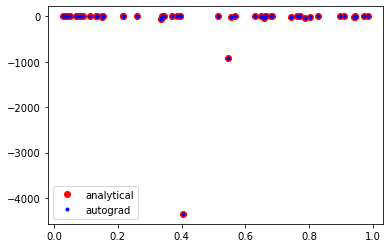

In [16]:
plt.plot(xr, -(xr**2) / yr**2, "ro", label="analytical")
plt.plot(xr, [dydx(_xr, _yr) for _xr, _yr in zip(xr, yr)], "b.", label="autograd")
plt.legend();

The output of True means the jax results and the analytical results are "all close", i.e. within a tolerance the results are the same. 

## Scientific applications



### Compressibility variation from an implicit equation of state



There are two ways to explore how some property varies with some parameter. One is if you have an equation relating them, you simply solve it many times for each parameter. Another is if you can derive an equation for how the property changes with parameter changes, then you have an ODE you can integrate. We explore that here. We will use the van der Waal equation of state to derive an equation for how the compressibility changes with the reduced pressure.

The general strategy to compute the compressibility as a function of pressure is to integrate $dV / dP_r$ over a range of $P_r$ to get the molar volume as a function of $P_r$, and then to directly compute the compressibility from $Z = PV/(RT)$.

To use this approach we need to get $dV / dP_r$ from the van der Waal equation. Here, we follow the work in the previous section to get the derivative from the implicit form of the van der Waal equation:

$f(V, P_r, T_r) = \frac{R Tr * Tc}{V - b} - \frac{a}{V^2} - P_r Pc = 0$

We can get

$dV/dP_r = (-df/dP_r) / (df/dV)$

and the two derivatives on the right can be found easily by automatic differentiation. First, we express the van der Waal equation in implicit form, with the variables as $V, P_r, T_r$. Only two of those variables are independent; if you define two of them you can compute the third one using a tool like fsolve.



In [17]:
R = 0.08206  # gas constant
Pc = 72.9
Tc = 304.2

a = 27 * R**2 * Tc**2 / (Pc * 64)
b = R * Tc / (8 * Pc)

Tr = 1.1  # Constant for this example, reduced temperature


def f(V, Pr, Tr):
    return R * Tr * Tc / (V - b) - a / V**2 - Pr * Pc

Now, if we want to know how does the volume vary with $P_r$, we need to derive the derivative $dV/dP_r$, and then integrate it. Here we use autograd to define the derivatives, and then we define a function that uses them. Note the arguments in the function dVdPr are in an order that anticipates we want to integrate it in solve\_ivp, to get a function $V(P_r)$.



In [18]:
dfdPr = grad(f, 1)  # derivative of f with respect to arg at index=1: Pr
dfdV = grad(f, 0)  # derivative of f with respect to arg at index=0: V


def dVdPr(Pr, V):
    V = V.squeeze() # V may be a 1-d array, so we squeeze that off so we have a scalar output.
    return -dfdPr(V, Pr, Tr) / dfdV(V, Pr, Tr)  # Tr is a constant in here

Now, we need an initial condition to start the integration from. We want the volume at $P_r=0.1$. We have to use `root` for this, or some other method that tells you want is the volume at $P_r=0.1$. We can pass the values of $P_r$ and $T_R$ as arguments to our implicit function. Since $V$ is the first argument, we can directly solve our implicit function. Otherwise you would have to define a helper objective function to use with fsolve.



In [19]:
from scipy.optimize import root

sol = root(f, 3.5, args=(0.1, 1.1))
sol.x  # V0

array([3.67647631])

Finally, we are ready to integrate the ODE, and plot the solution.



The solver successfully reached the end of the integration interval.


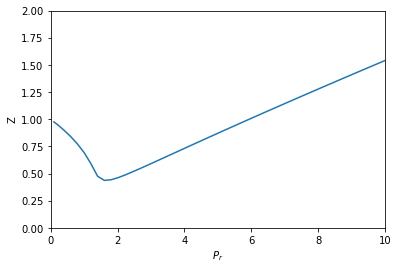

In [20]:
from scipy.integrate import solve_ivp

Pr_span = (0.1, 10)
Pr_eval, h = np.linspace(*Pr_span, retstep=True)

V0, = sol.x

sol = solve_ivp(dVdPr, Pr_span, (V0,), max_step=h)
print(sol.message)

import matplotlib.pyplot as plt

Pr = sol.t  # the P_r steps used in the solution
V = sol.y[0]  # V(P_r) from the solution

Z = Pr * Pc * V / (R * Tr * Tc)  # Compressibility Z(P_r)

plt.plot(Pr, Z)
plt.xlabel("$P_r$")
plt.ylabel("Z")
plt.xlim([0, 10])
plt.ylim([0, 2]);

There are several advantages of doing this over iteratively solving with fsolve. The biggest one is no initial guesses! It is also faster. What do you think would happen if there were multiple roots in the equation?



### Computing the pressure from a solid equation of state



A solid equation of state describes the energy of a solid under isotropic strain. We can readily compute the pressure at a particular volume from the equation:

$P = -\frac{dE}{dV}$

We just need the derivative of this equation:

$E = E_0+\frac{B_0 V}{B'_0}\left[\frac{(V_0/V)^{B'_0}}{B'_0-1}+1\right]-\frac{V_0 B_0}{B'_0-1}$

We use autograd to get it for us.



In [21]:
E0, B0, BP, V0 = -56.466, 0.49, 4.753, 16.573


def Murnaghan(vol):
    E = (
        E0
        + B0 * vol / BP * (((V0 / vol) ** BP) / (BP - 1.0) + 1.0)
        - V0 * B0 / (BP - 1.0)
    )
    return E


def P(vol):
    dEdV = grad(Murnaghan)
    return -dEdV(vol) * 160.21773  # in Gpa


print(P(V0))  # Pressure at the minimum in energy is zero
print(P(0.99 * V0))  # Compressed
print(P(1.01 * V0))

-0.0
0.8081676846907757
-0.7629830762001816


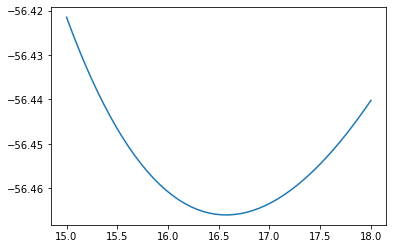

In [22]:
V = np.linspace(15, 18)
plt.plot(V, Murnaghan(V));

So it takes positive pressure to compress the system, as expected, and at the minimum the pressure is equal to zero. Seems pretty clear autograd is better than deriving the required pressure derivative.



### Sensitivity analysis using automatic differentiation in Python



This [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.428.6699&rep=rep1&type=pdf) describes how sensitivity analysis requires access to the derivatives of a function. Say, for example we have a function describing the time evolution of the concentration of species A:

$[A] = \frac{[A]_0}{k_1 + k_{-1}} (k_1 e^{(-(k_1 + k_{-1})t)} + k_{-1})$

The local sensitivity of the concentration of A to the parameters $k1$ and $k_1$ are defined as $\frac{\partial A}{\partial k_1}$ and $\frac{\partial A}{\partial k_{-1}}$. Our goal is to plot the sensitivity as a function of time. We could derive those derivatives, but we will use auto-differentiation instead through the autograd package.



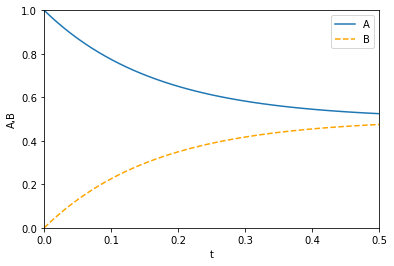

In [23]:
A0 = 1.0

def A(t, k1, k_1):
    return A0 / (k1 + k_1) * (k1 * np.exp(-(k1 + k_1) * t) + k_1)

t = np.linspace(0, 0.5)

k1 = 3.0
k_1 = 3.0
plt.plot(t, A(t, k1, k_1), label="A")
plt.plot(t, A0 - A(t, k1, k_1), "--", color="orange", label="B")
plt.xlim([0, 0.5])
plt.ylim([0, 1])
plt.xlabel("t")
plt.ylabel("A,B")
plt.legend();

The figure above reproduces Fig. 1 from the paper referenced above.  Next, we use autograd to get the derivatives. We need the derivative of the function with respect to the second and third arguments; the default is the first argument. Second, we want to evaluate this derivative at each time value.  Finally, to reproduce Figure 2a, we plot the absolute value of the sensitivities.



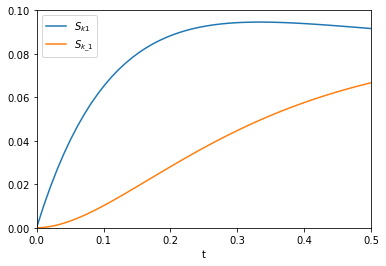

In [25]:
fdAdk1 = jacrev(A, 1)  # k1
fdAdk_1 = jacrev(A, 2)  # k_1

dAdk1 = fdAdk1(t, k1, k_1) 
dAdk_1 = fdAdk_1(t, k1, k_1) 

plt.plot(t, np.abs(dAdk1))
plt.plot(t, np.abs(dAdk_1))
plt.xlim([0, 0.5])
plt.ylim([0, 0.1])
plt.xlabel("t")
plt.legend(["$S_{k1}$", "$S_{k\_1}$"]);

That looks like the figure in the paper. To summarize the main takeaway, autograd enabled us to readily compute derivatives without having to derive them manually.



## Summary



These are just some of *many* possible applications of automatic differentiation in mathematics and engineering. The key points you should take away from this is that it is often possible to program with derivatives, and to compute derivatives automatically in many cases. This enables you to think about writing programs that reflect the mathematical and scientific ideas you are trying to implement more directly, and in many cases less approximately.

